# Helpful (hopefully) notes and general measurement tips

- **Spectrum Analyzer:** The spectrum analyzer tends to timeout if it hasn't been used in a while. To restart it, simply execute the qubit initialization again or use the qb._instrument.set() command to send a value and wake the instrument back up.
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qubit import qubit
import numpy as np
import plot_functions as pf

2024-04-25 14:48:10,335 - qm - INFO     - Starting session: 2cb13538-a40a-474a-a19f-7ef7b04082b1


# Initialize qubit

In [3]:
qb = qubit('ocs2')

Loading parameter JSON file
2024-04-25 14:48:13,298 - qm - INFO     - Performing health check
2024-04-25 14:48:13,310 - qm - INFO     - Health check passed
Loading instrument settings from experiments\test\test_instruments.json.
Initializing readout_LO (SignalCore SC5511A Signal Generator).
Initializing qubit_LO (SignalCore SC5511A Signal Generator).
Initializing DA (Vaunix Lab Brick Digital Attenuator).
Initializing sa (SignalHound SpectrumAnalyzer).
Setting readout_LO frequency to 7568050000.0.
Setting readout_LO output to True.
Setting qubit_LO frequency to 7000000000.0.
Setting qubit_LO power to 17.
Setting qubit_LO output to True.
Setting DA attenuation to 27.


# Time of flight

For tof calibration, we don't need the resontor frequency per se

Updating readout_atten to 0
Setting DA attenuation to 0.
Updating tof to 56
Updating smearing to 10
Updating n_avg to 1000
Updating rr_IF to 5000000.0
Updating readout_length to 1000
2024-04-25 14:48:16,794 - qm - INFO     - Performing health check
2024-04-25 14:48:16,816 - qm - INFO     - Health check passed
2024-04-25 14:48:17,082 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:48:17,134 - qm - INFO     - Executing program
Updating tof to 216
Input 1 Offset: -6.995910405177696 mV
Input 2 Offset: -3.7087859509038 mV
Updating analog_input_offsets to [-0.08783167389514399, -0.06213500426049325]


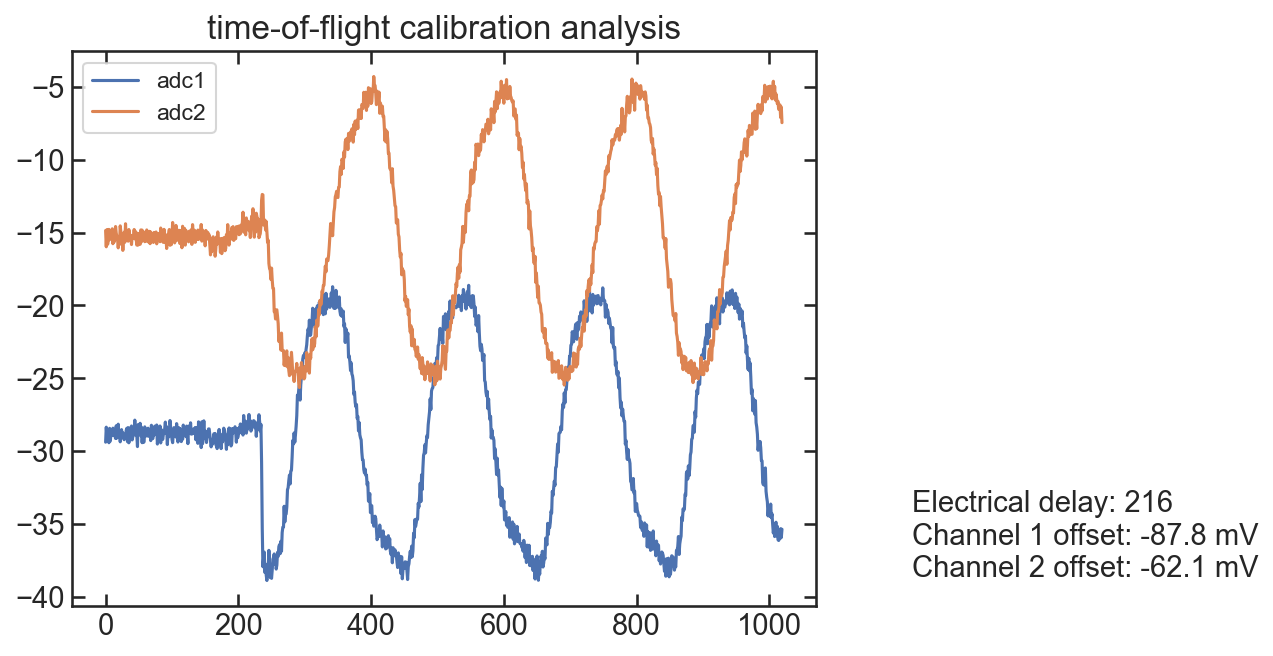

In [4]:
qb.update_value('readout_atten',0)
qb.update_value('tof',56) #clock cycles
qb.update_value('smearing',10)
qb.update_value('n_avg',1000)
qb.update_value('rr_IF',5e6) 
qb.update_value('readout_length',1000)

adc1,adc2 = qb.tof_cal(update_tof=True)
pf.tof_plot(adc1, adc2,delay=qb.pars['tof'],offsets=qb.pars['analog_input_offsets'])

2024-04-25 13:54:44,521 - qm - INFO     - Performing health check
2024-04-25 13:54:44,532 - qm - INFO     - Health check passed
2024-04-25 13:54:44,764 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:54:44,802 - qm - INFO     - Executing program
Updating tof to 292
Input 1 Offset: -0.02431185853247557 mV
Input 2 Offset: 0.007041302849264626 mV
Updating analog_input_offsets to [-0.0948805305032169, -0.06564756338082108]


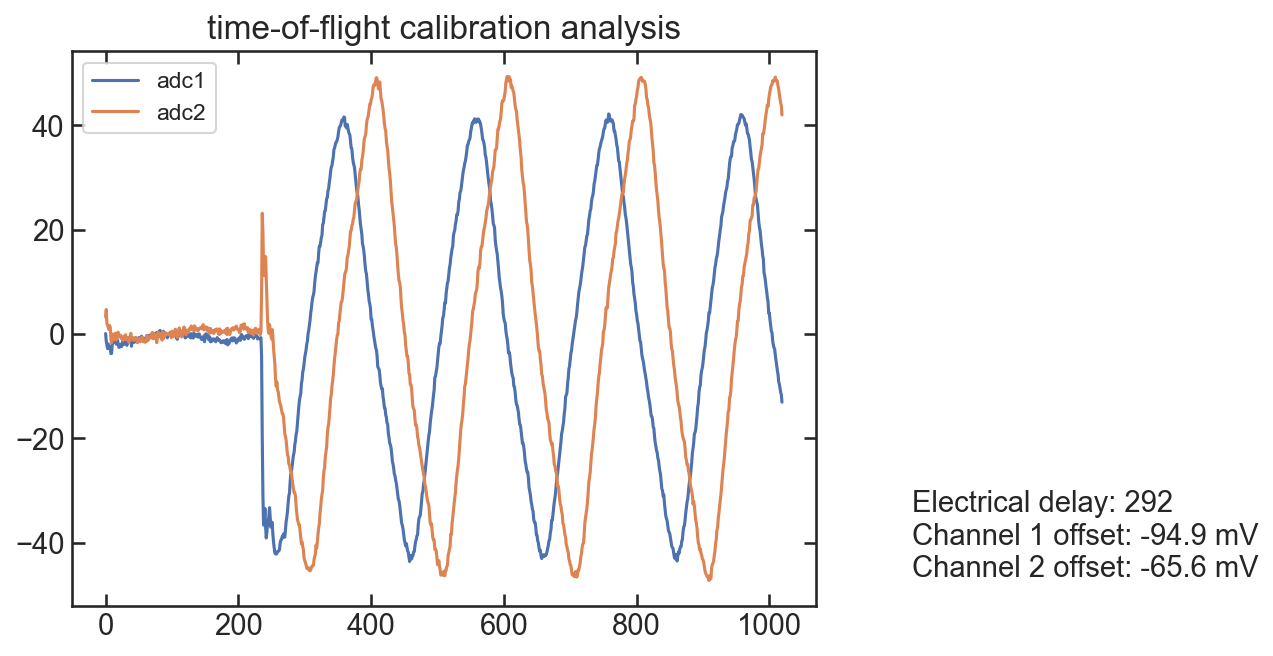

In [13]:
adc1,adc2 = qb.tof_cal(update_tof=True)
pf.tof_plot(adc1, adc2,delay=qb.pars['tof'],offsets=qb.pars['analog_input_offsets'])

**Note:** execute the following cell to visually see if the tof is calibrated

2024-04-25 13:54:48,545 - qm - INFO     - Performing health check
2024-04-25 13:54:48,564 - qm - INFO     - Health check passed
2024-04-25 13:54:48,681 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:54:48,722 - qm - INFO     - Executing program
Input 1 Offset: -0.052946202895220576 mV
Input 2 Offset: 0.19622683057598056 mV
Updating analog_input_offsets to [-0.09482758430032168, -0.06584379021139705]


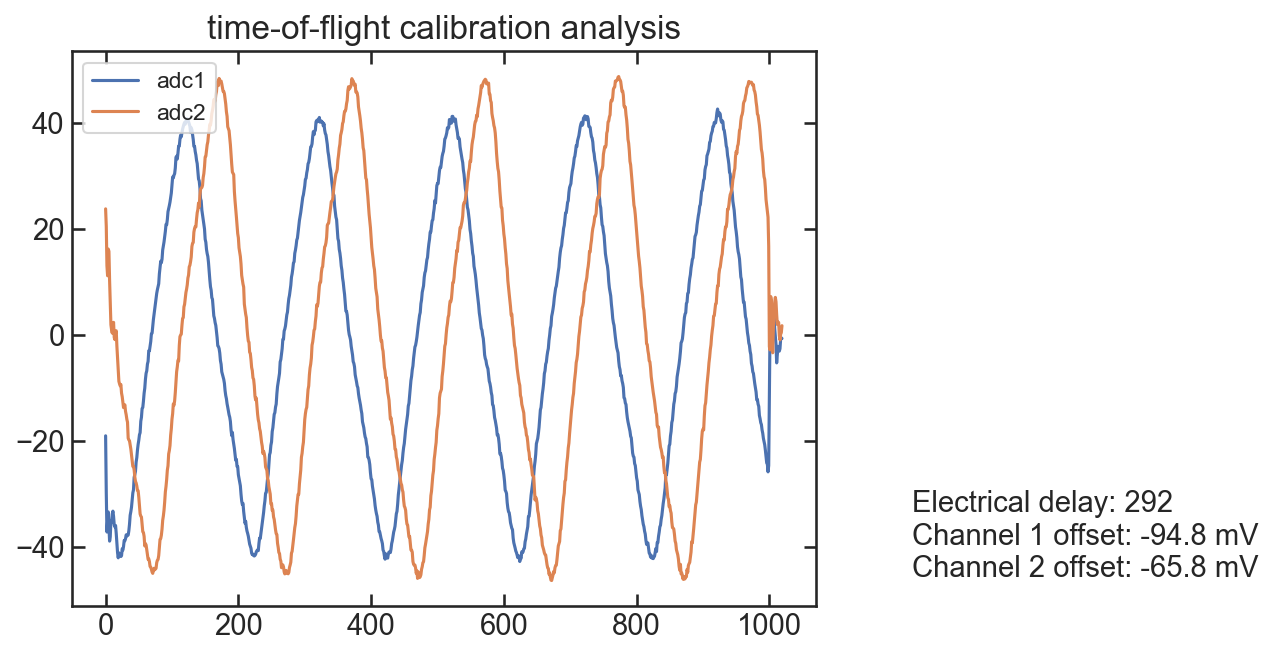

In [14]:
adc1,adc2 = qb.tof_cal(update_tof=False)
pf.tof_plot(adc1, adc2,delay=qb.pars['tof'],offsets=qb.pars['analog_input_offsets'])

# Optimize Mixers

Starting with the smallest resonator

In [15]:
LO_freq = 7.5e9 #Hz (targets the smallest resonator)

In [16]:
# qb.update_value('rr_freq',7.6146e9)
qb.pars['rr_IF']

5000000.0

## Minimize LO leakage 

## Resonator

Updating rr_LO to 6195000000.0
Setting readout_LO frequency to 6195000000.0.
Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 6195000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.
LO at 6.195 GHz
Current I_offset = 0.0 mV, Current Q_offset = 0.0 mV
Setting sa frequency to 6195000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -32.83576583862305.
Setting sa bandwidth to 1000.0.


100%|██████████| 121/121 [00:13<00:00,  9.02it/s]


Updating rr_mixer_offsets to [-0.00505, 0.0009500000000000003]
optimal I_offset = -5.0 mV, optimal Q_offset = 1.0 mV
Updating readout_atten to 0
Setting DA attenuation to 0.
Power: -63.6503791809082 dBm at 6.195 GHz


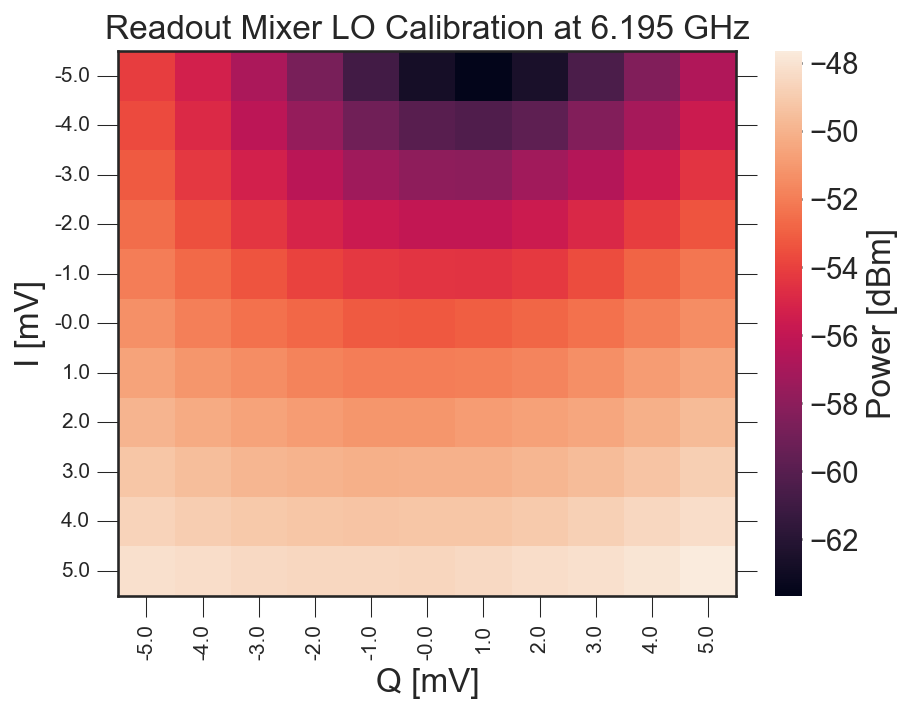

In [17]:
# qb.update_value('rr_LO',LO_freq)
qb.update_value('rr_LO',qb.pars['rr_freq']-qb.pars['rr_IF'])
# qb.get_power(fc=qb.pars['rr_LO'],threshold=-20,span=1e6,config=True,plot=True)
qb.opt_lo_leakage(mode='coarse',element='rr',sa_span=0.5e6,threshold=-20,plot=True)

## Minimize image sideband

Updating rr_IF to 50000000.0
2024-04-25 13:56:47,563 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:56:47,585 - qm - INFO     - Executing program
Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 6145000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.


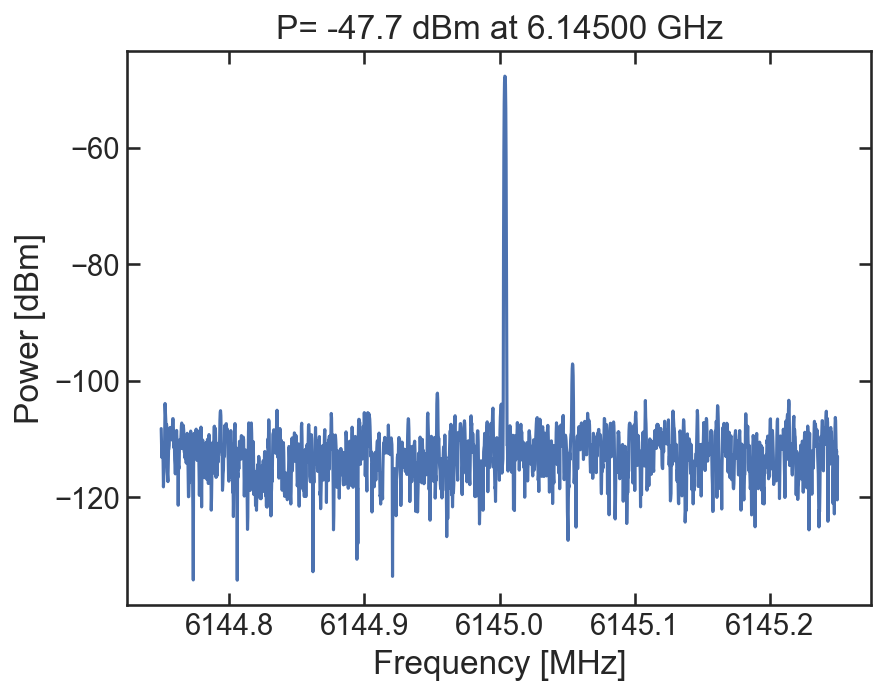

-47.6912956237793 dBm at 6.145003931440735 GHz
Sideband at 6.145 GHz
Current gain = 0, Current phase = 0


100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


Updating rr_mixer_imbalance to (-0.011111111111111113, -0.19444444444444445)
optimal gain = -0.0111, optimal phi = -0.1944
Updating readout_atten to 0
Setting DA attenuation to 0.
Power: -72.31948852539062 dBm at 6.145 GHz


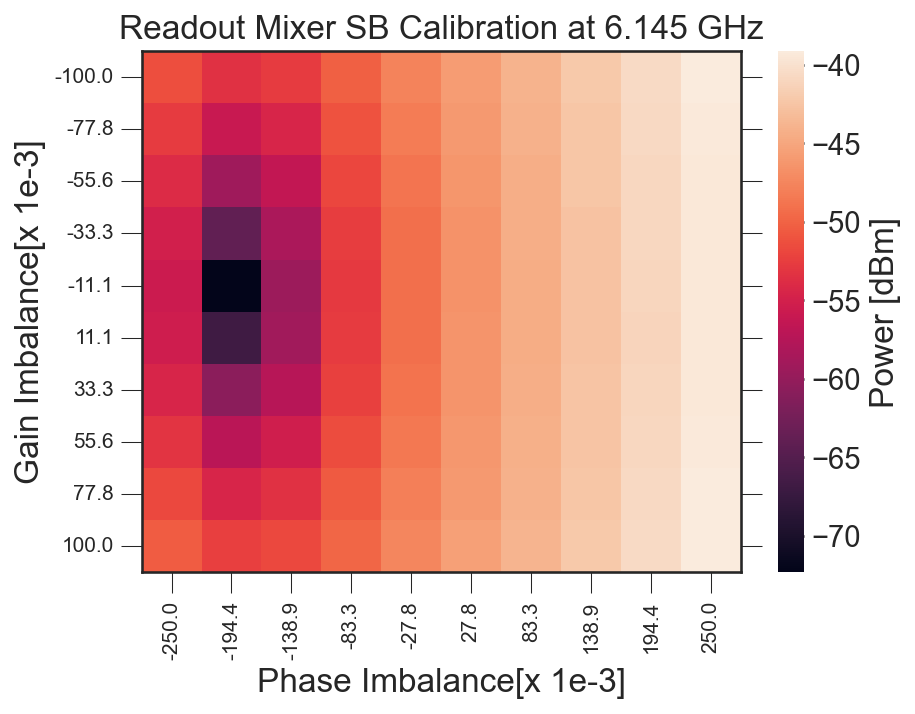

In [18]:
qb.update_value('rr_IF',50e6)
qb.opt_sideband(mode='coarse',element='rr',sa_span=0.5e6,threshold=-20,plot=True)

2024-04-25 13:56:59,446 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:56:59,469 - qm - INFO     - Executing program
Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 6145000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -50.
Setting sa bandwidth to 1000.0.


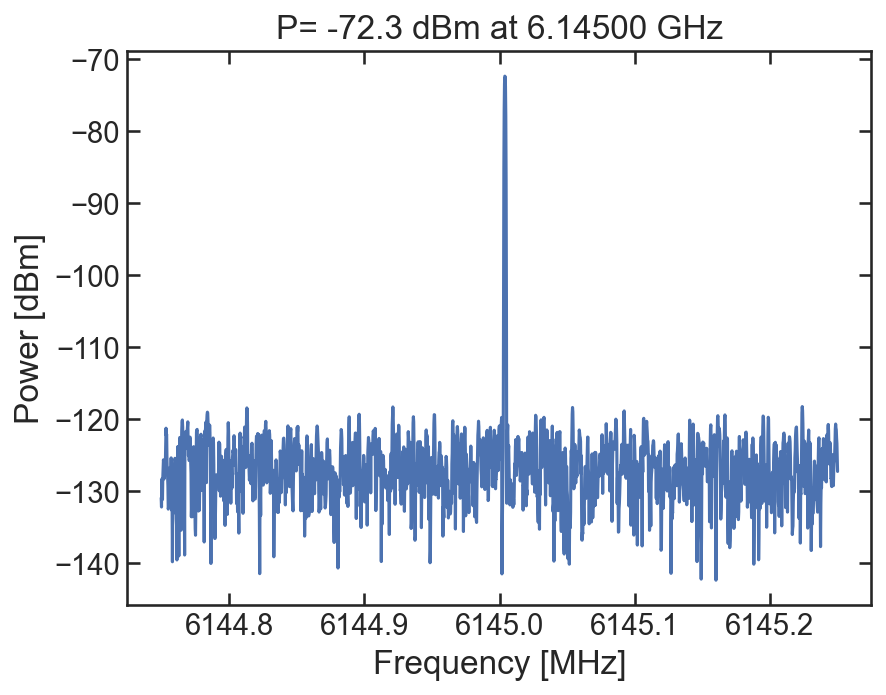

-72.34054565429688 dBm at 6.145003931440735 GHz
Sideband at 6.145 GHz
Current gain = -0.0111, Current phase = -0.1944


100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


Updating rr_mixer_imbalance to (0.0, -0.16666666666666663)
optimal gain = 0.0, optimal phi = -0.1667
Updating readout_atten to 0
Setting DA attenuation to 0.
Power: -67.08905029296875 dBm at 6.145 GHz


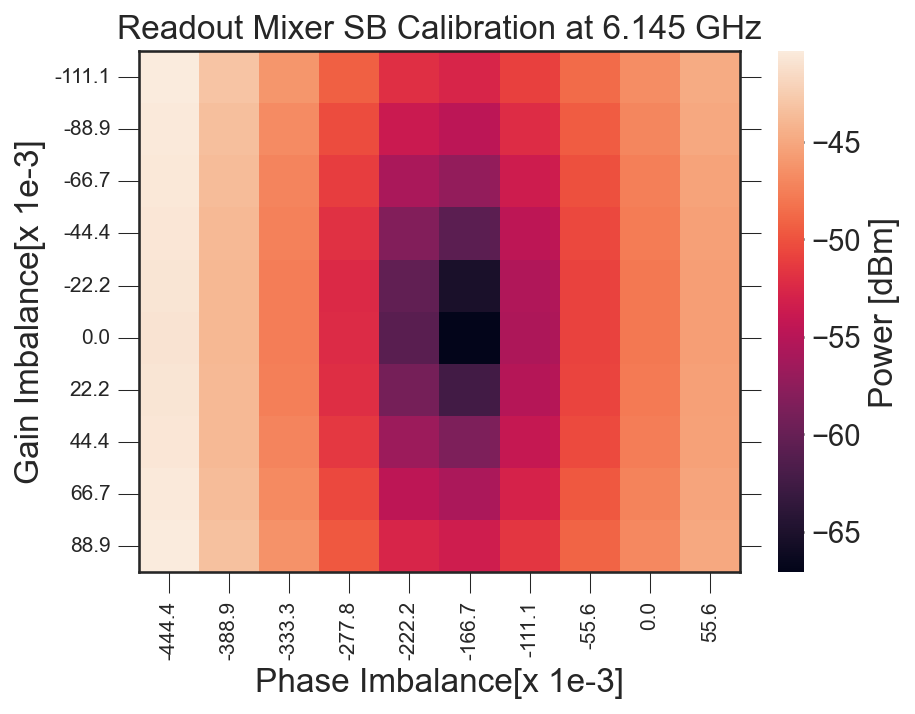

In [19]:
qb.opt_sideband(mode='coarse',element='rr',sa_span=0.5e6,threshold=-50,plot=True)

# Resonator spectroscopy

**Notes on resonator spectroscopy**

In [20]:
IF_min, IF_max = 36e6, 41.5e6
df_resonator_spec = 0.05e6

In [22]:
qb.update_value('readout_length', 5000)   #ns (since resonator is narrow)
qb.pars['resettime']['rr'] = 5000 # clock cycles
qb.write_pars()
qb.update_value('n_avg',3000)
qb.update_value('readout_atten',10)
df_resonator_spec = 0.05e6
qb.experiment = 'resonator_spec'
##added a 10db fixed attenuator on rr line after the spiltter and just before fridge input
data, job = qb.resonator_spec(
                       f_LO = 7.8e9,
                       IF_min = IF_min,
                       IF_max = IF_max,
                       df = df_resonator_spec,
                       fit=True,
                       on_off=False,
                       savedata=True,
                       showprogress=True)

Updating readout_length to 5000
Updating n_avg to 3000
Updating readout_atten to 10
Setting DA attenuation to 10.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:57:24,953 - qm - INFO     - Performing health check
2024-04-25 13:57:24,966 - qm - INFO     - Health check passed
2024-04-25 13:57:25,289 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:57:25,652 - qm - INFO     - Executing program


100%|█████████▉| 2999/3000 [00:13<00:00, 221.47it/s]


Saving data to G:\Shared drives\Quasiparticles\OCS_QP\data\ocs2\resonator_spec\rr


Resonant Frequency: 7.83635 GHz
FWHM = 0.3 MHz
kappa = 1.885 MHz


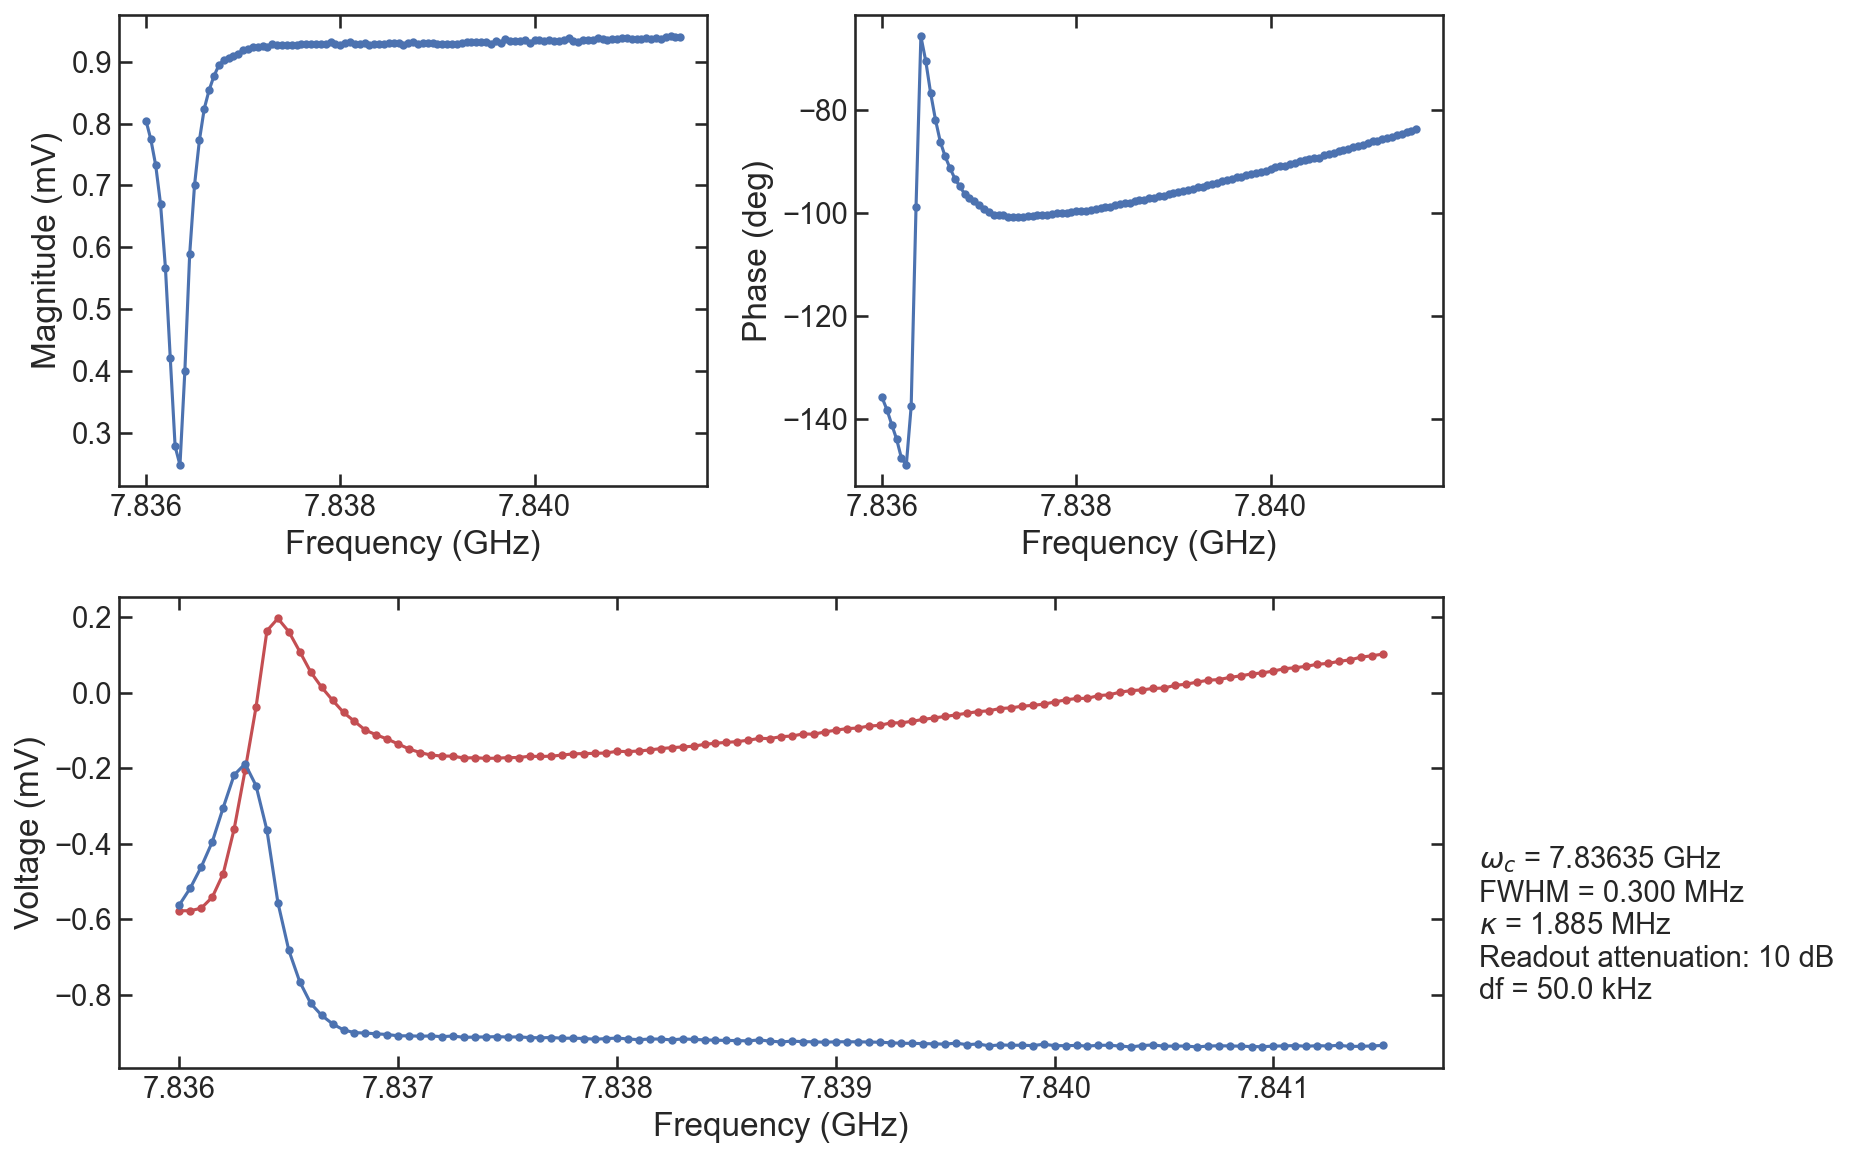

In [23]:
fc,fwhm = pf.fit_res(data['freqs'],data['I'],data['Q'])
pf.resonator_spec_plot(data,qb_pars=qb.pars,fwhm=fwhm,fc=fc)

In [24]:
from resonator import Resonator

In [25]:
res = Resonator(port_type='n',f_data=data['freqs'],z_data=data['I']+1j*data['Q'])
res.autofit(electric_delay=0)
res.show()

fit error = [4.96241112e-06 1.59523183e-01 5.31290628e-01]
The fit could not be found, try cropping the data with autofit(fcrop=(f1 [GHz],f2 [GHz]))


AttributeError: 'Resonator' object has no attribute 'z_data_sim'

# Qubit Punchout

In [26]:
attenuations = np.arange(0,50,5)
qb.update_value('n_avg',2000)
data, job = qb.punchout(df = 0.05e6,
                 IF_min = IF_min,
                 IF_max = IF_max,
                 attenuations=attenuations,
                 savedata=False)

Updating n_avg to 2000


  0%|          | 0/10 [00:00<?, ?it/s]

Attenuation = 0 dB
Setting DA attenuation to 0.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:58:07,831 - qm - INFO     - Performing health check
2024-04-25 13:58:07,847 - qm - INFO     - Health check passed
2024-04-25 13:58:08,436 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:58:08,644 - qm - INFO     - Executing program


 10%|█         | 1/10 [00:10<01:34, 10.45s/it]

Attenuation = 5 dB
Setting DA attenuation to 5.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:58:18,009 - qm - INFO     - Performing health check
2024-04-25 13:58:18,021 - qm - INFO     - Health check passed
2024-04-25 13:58:18,388 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:58:18,600 - qm - INFO     - Executing program


 20%|██        | 2/10 [00:20<01:21, 10.16s/it]

Attenuation = 10 dB
Setting DA attenuation to 10.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:58:27,971 - qm - INFO     - Performing health check
2024-04-25 13:58:27,984 - qm - INFO     - Health check passed
2024-04-25 13:58:28,327 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:58:28,532 - qm - INFO     - Executing program


 30%|███       | 3/10 [00:30<01:10, 10.04s/it]

Attenuation = 15 dB
Setting DA attenuation to 15.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:58:38,032 - qm - INFO     - Performing health check
2024-04-25 13:58:38,050 - qm - INFO     - Health check passed
2024-04-25 13:58:38,656 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:58:38,922 - qm - INFO     - Executing program


 40%|████      | 4/10 [00:40<01:01, 10.17s/it]

Attenuation = 20 dB
Setting DA attenuation to 20.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:58:48,274 - qm - INFO     - Performing health check
2024-04-25 13:58:48,286 - qm - INFO     - Health check passed
2024-04-25 13:58:48,633 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:58:48,815 - qm - INFO     - Executing program


 50%|█████     | 5/10 [00:50<00:50, 10.08s/it]

Attenuation = 25 dB
Setting DA attenuation to 25.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:58:58,191 - qm - INFO     - Performing health check
2024-04-25 13:58:58,204 - qm - INFO     - Health check passed
2024-04-25 13:58:58,624 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:58:58,850 - qm - INFO     - Executing program


 60%|██████    | 6/10 [01:00<00:40, 10.09s/it]

Attenuation = 30 dB
Setting DA attenuation to 30.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:59:08,453 - qm - INFO     - Performing health check
2024-04-25 13:59:08,466 - qm - INFO     - Health check passed
2024-04-25 13:59:09,072 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:59:09,347 - qm - INFO     - Executing program


 70%|███████   | 7/10 [01:11<00:30, 10.20s/it]

Attenuation = 35 dB
Setting DA attenuation to 35.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:59:18,709 - qm - INFO     - Performing health check
2024-04-25 13:59:18,721 - qm - INFO     - Health check passed
2024-04-25 13:59:19,145 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:59:19,322 - qm - INFO     - Executing program


 80%|████████  | 8/10 [01:21<00:20, 10.13s/it]

Attenuation = 40 dB
Setting DA attenuation to 40.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:59:28,710 - qm - INFO     - Performing health check
2024-04-25 13:59:28,722 - qm - INFO     - Health check passed
2024-04-25 13:59:29,266 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:59:29,471 - qm - INFO     - Executing program


 90%|█████████ | 9/10 [01:31<00:10, 10.13s/it]

Attenuation = 45 dB
Setting DA attenuation to 45.
Updating rr_LO to 7800000000.0
Setting readout_LO frequency to 7800000000.0.
2024-04-25 13:59:39,017 - qm - INFO     - Performing health check
2024-04-25 13:59:39,034 - qm - INFO     - Health check passed
2024-04-25 13:59:39,565 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 13:59:39,826 - qm - INFO     - Executing program


100%|██████████| 10/10 [01:41<00:00, 10.17s/it]

Setting DA attenuation to 10.


Dispersive shift: -63662.0 kHz
Resonant Frequency: 0.00000 GHz
FWHM = 2.500000000003055e-10 MHz
kappa = 0.000 MHz
Resonant Frequency: 0.00000 GHz
FWHM = 4.499999999998394e-10 MHz
kappa = 0.000 MHz


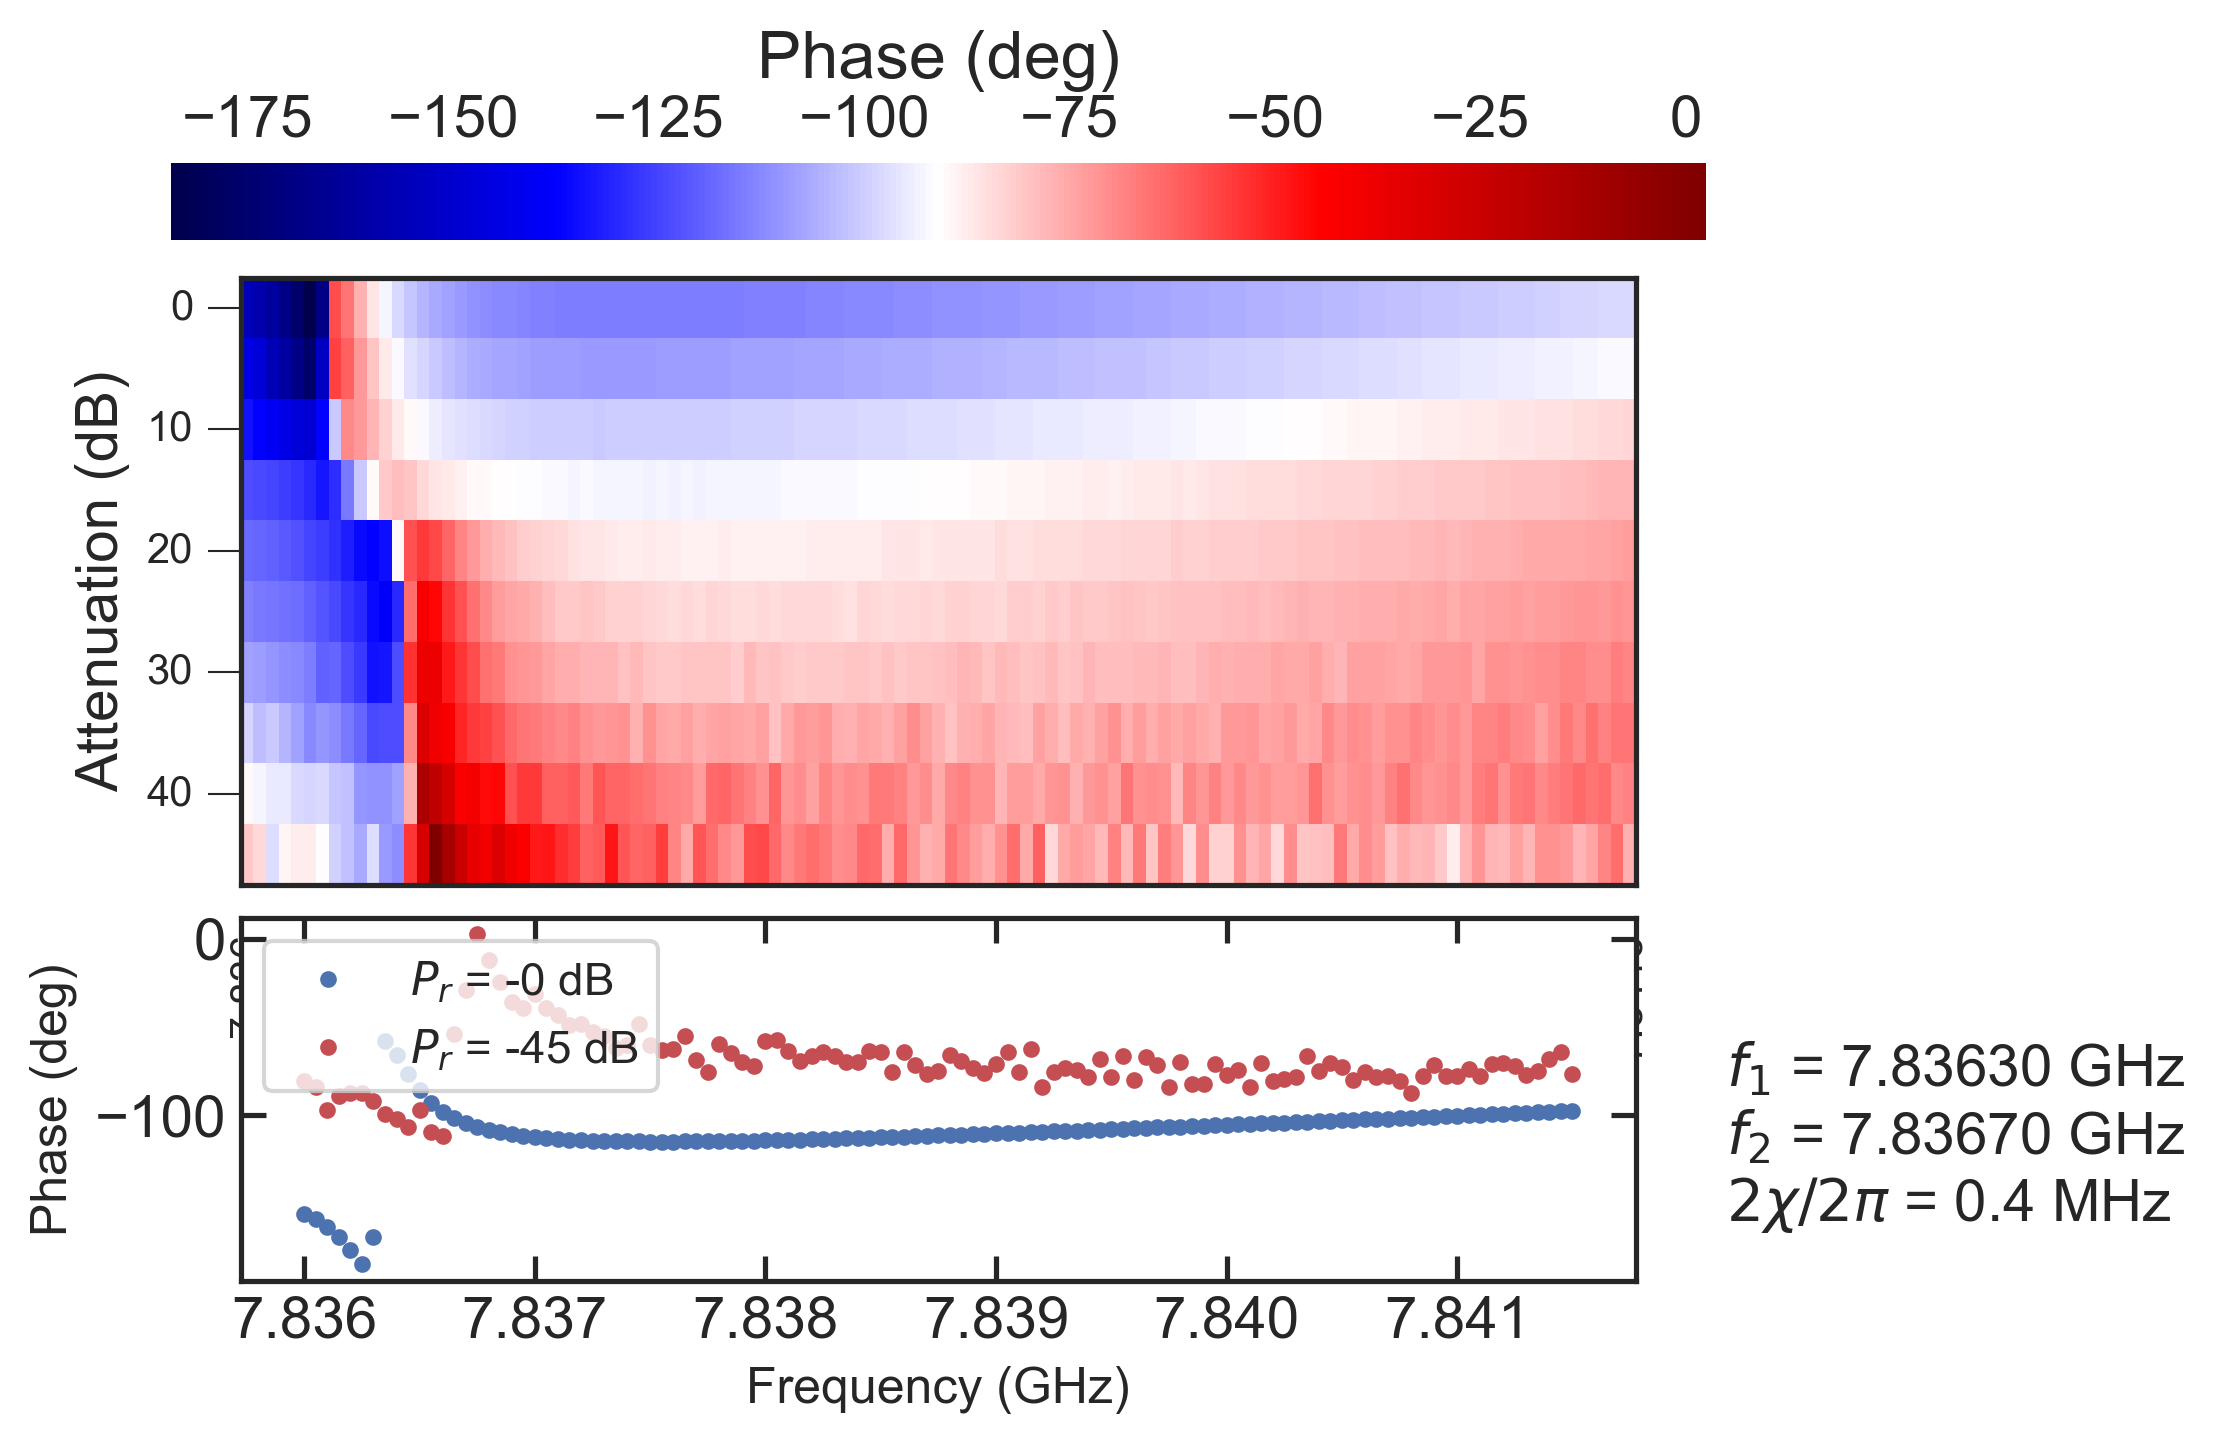

In [27]:
pf.punchout_plot(data,xlabel='Frequency (GHz)',ylabel='Attenuation (dB)',cbar_label='Phase (deg)')

In [28]:
qb.update_value('rr_atte')

TypeError: update_value() missing 1 required positional argument: 'value'

# Qubit Spectroscopy

The first time we run qubit spectroscopy we have to use a high qubit driving amplitude for a couple of reasons. 
1. Detect higher levels like $\omega_{02}/2$ and $\omega_{03}/3$ so you can calculate anharmonicity.
2. Since you don't know exactly what the qubit frequency is going to be (unless you've nailed the fab process), you will have to execute a broad sweep. Driving the qubit at high power broadens the resonance (decreases coherence), makes it easier to detect $\omega_{01}$ -> frequency spacing can be larger.

## Narrow search

In [29]:
qb.pars['qubit_IF']

50000000.0

Updating qubit_LO to 6000000000.0
Setting qubit_LO frequency to 6000000000.0.
Setting sa frequency to 6000000000.0.
Setting sa span to 1000000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.


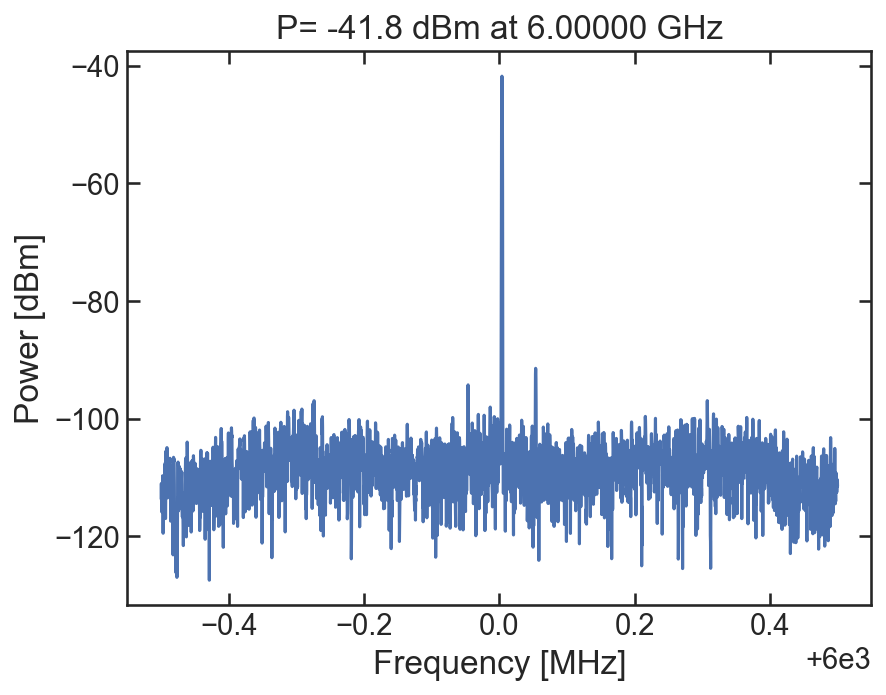

-41.7581787109375 dBm at 6.00000365460759 GHz


-41.75818

In [30]:
qb.update_value('qubit_LO',6e9)
qb.get_power(fc=qb.pars['qubit_LO'],threshold=-20,sa_span=1e6,config=True,plot=True)   

Updating n_avg to 5000
Updating rr_freq to 7618050000.0
Updating readout_atten to 27
Setting DA attenuation to 27.
Updating rr_LO to 7568050000.0
Setting readout_LO frequency to 7568050000.0.
Updating qubit_LO to 6600000000.0
Setting qubit_LO frequency to 6600000000.0.
Setting sa frequency to 6600000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -30.
Setting sa bandwidth to 1000.0.
LO at 6.6 GHz
Current I_offset = 0.0 mV, Current Q_offset = 0.0 mV
Setting sa frequency to 6600000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -21.909114837646484.
Setting sa bandwidth to 1000.0.


100%|██████████| 121/121 [00:13<00:00,  9.23it/s]


Updating qubit_mixer_offsets to [-0.00505, -0.00505]
optimal I_offset = -5.0 mV, optimal Q_offset = -5.0 mV
Power: -48.24897384643555 dBm at 6.6 GHz


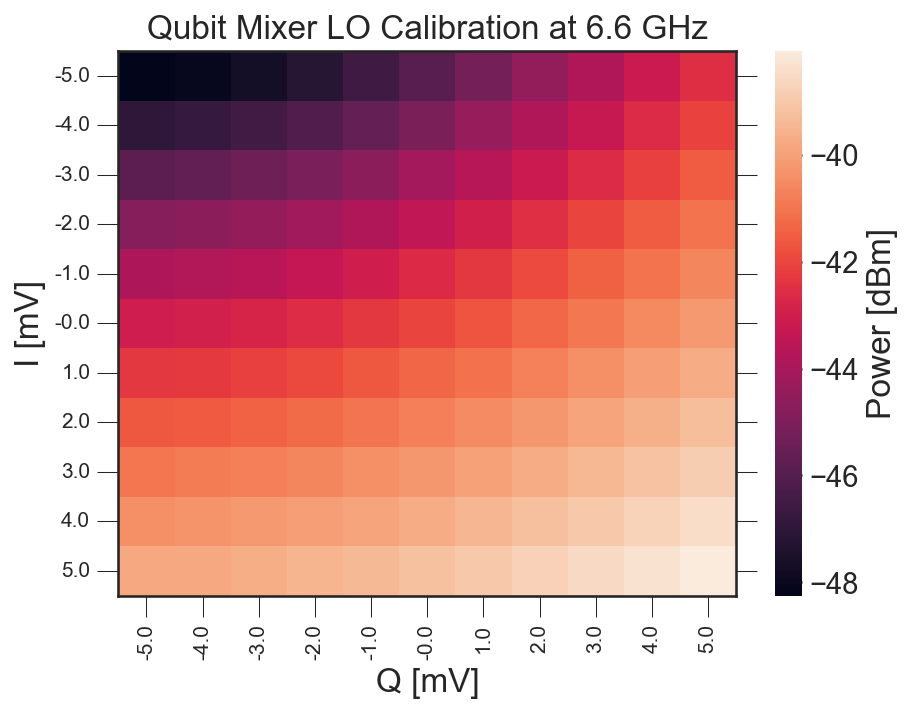

Updating qubit_IF to 50000000.0
2024-04-25 14:00:45,439 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:00:45,461 - qm - INFO     - Executing program
Setting sa frequency to 6550000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.


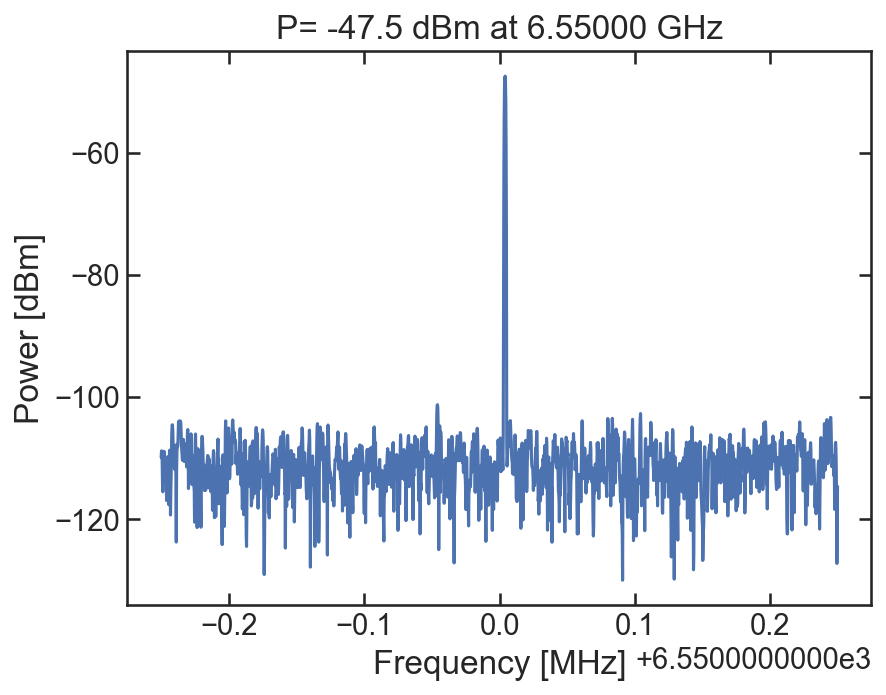

-47.453102111816406 dBm at 6.550004042005734 GHz
Sideband at 6.55 GHz
Current gain = 0, Current phase = 0


100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


Updating qubit_mixer_imbalance to (0.011111111111111113, -0.08333333333333334)
optimal gain = 0.0111, optimal phi = -0.0833
Power: -72.44963073730469 dBm at 6.55 GHz


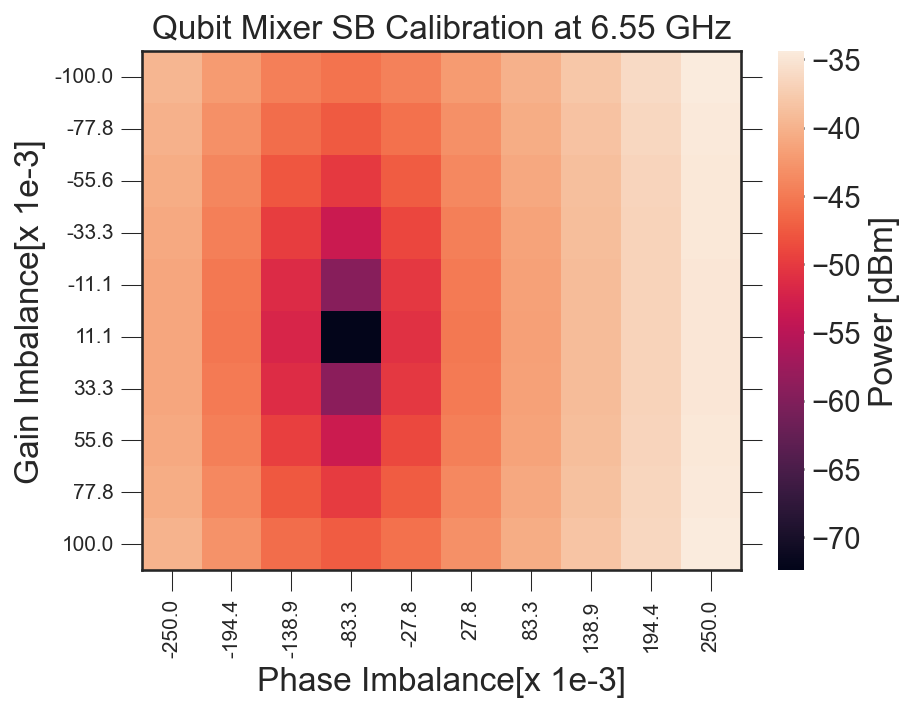

Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 7568050000.0.
Setting sa span to 500000.0.
Setting sa threshold to -30.
Setting sa bandwidth to 1000.0.
LO at 7.56805 GHz
Current I_offset = -5.0 mV, Current Q_offset = 1.0 mV
Setting sa frequency to 7568050000.0.
Setting sa span to 500000.0.
Setting sa threshold to -34.15118408203125.
Setting sa bandwidth to 1000.0.


100%|██████████| 121/121 [00:13<00:00,  9.06it/s]


Updating rr_mixer_offsets to [-0.006100000000000003, 0.0019000000000000006]
optimal I_offset = -6.1 mV, optimal Q_offset = 1.9 mV
Updating readout_atten to 27
Setting DA attenuation to 27.
Power: -76.80986785888672 dBm at 7.56805 GHz


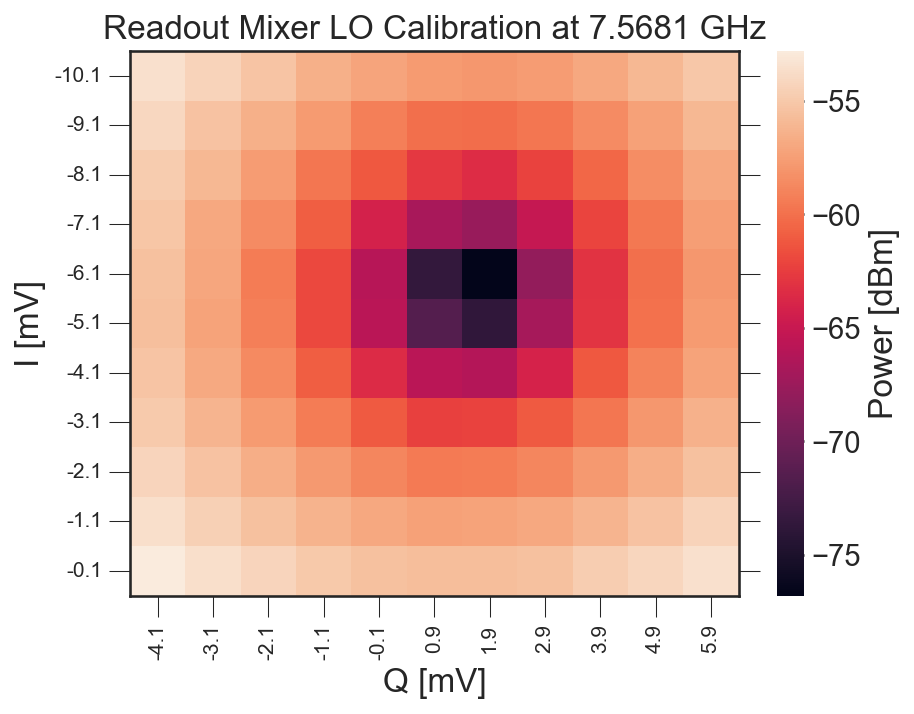

Updating rr_IF to 50000000.0
2024-04-25 14:01:12,546 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:01:12,569 - qm - INFO     - Executing program
Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 7518050000.0.
Setting sa span to 500000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.


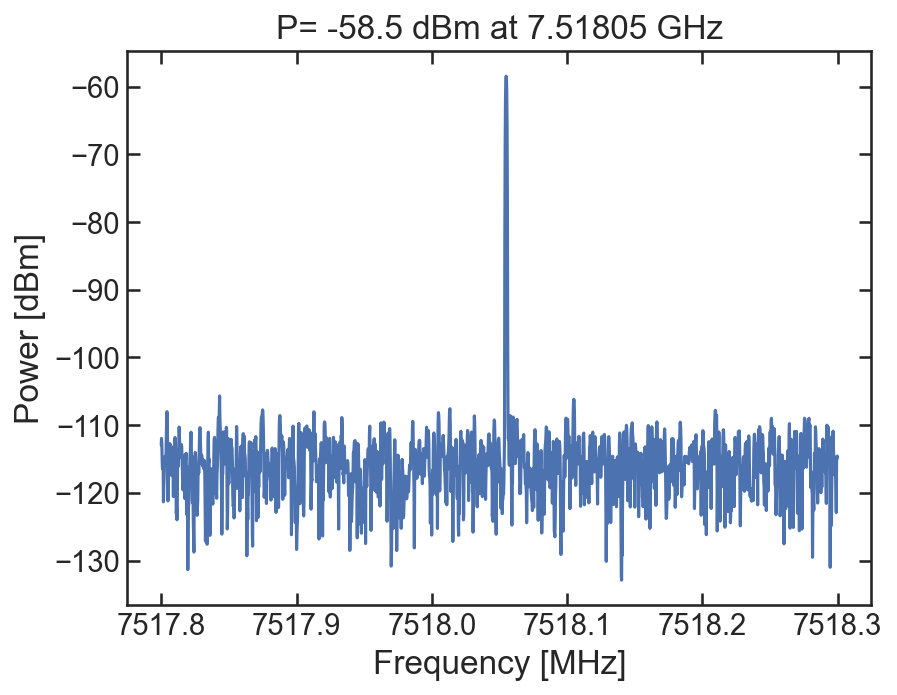

-58.470497131347656 dBm at 7.51805484009136 GHz
Sideband at 7.51805 GHz
Current gain = 0.0, Current phase = -0.1667


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


Updating rr_mixer_imbalance to (-0.011111111111111113, -0.13888888888888884)
optimal gain = -0.0111, optimal phi = -0.1389
Updating readout_atten to 27
Setting DA attenuation to 27.
Power: -64.8248062133789 dBm at 7.51805 GHz


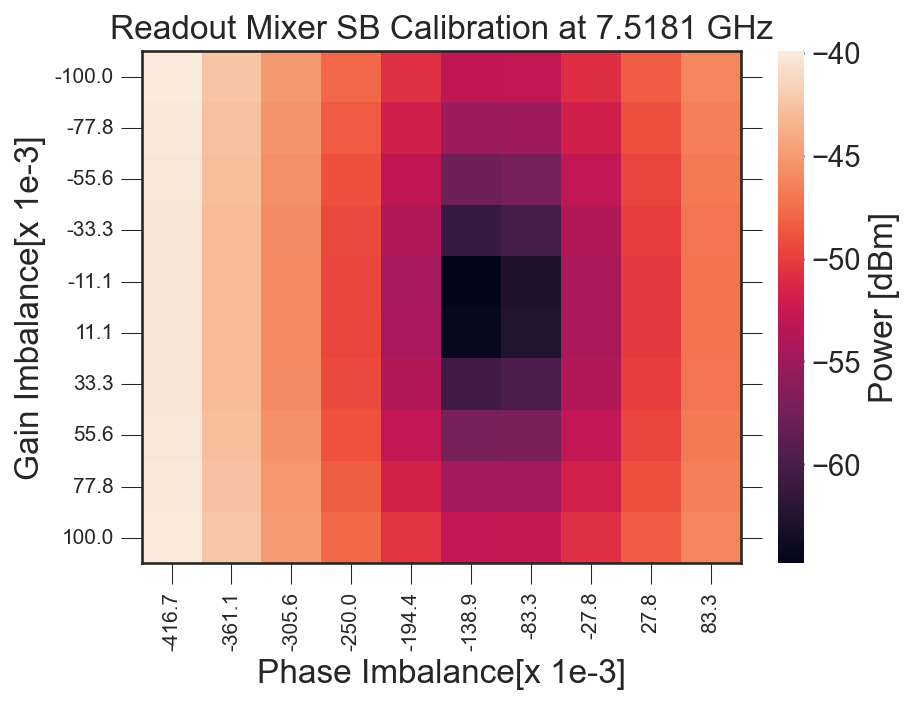

2024-04-25 14:01:24,197 - qm - INFO     - Performing health check
2024-04-25 14:01:24,208 - qm - INFO     - Health check passed
2024-04-25 14:01:24,527 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:01:24,723 - qm - INFO     - Executing program


100%|█████████▉| 4999/5000 [04:38<00:00, 17.93it/s]


In [31]:
amp_q_scaling = 1
qb.update_value('n_avg',5000)
qb.update_value('rr_freq', 7.61805e9)
# qb.update_value('rr_IF', 50e6)
# qb.update_value('smearing',40)
# qb.update_value('tof',292)
qb.update_value('readout_atten',27)
qb.update_value('rr_LO', qb.pars['rr_freq'] - qb.pars['rr_IF'])
qb.pars['resettime']['qubit'] = int(20e3)
qb.write_pars()
qb.experiment = 'qubit_spec'
data, job = qb.qubit_spec(element='qubit',
                                check_mixers=True,
                                IF_min=50e6,
                                IF_max=200e6,
                                f_LO=6.6e9,
                                df=0.5e6,
                                on_off=True,
                                amp_q_scaling = amp_q_scaling,
                                saturation_dur = 20e3,
                                showprogress=True,
                                savedata=False)

Peak threshold at 0.0049789920423859105
Peaks at: 6.6755 GHz



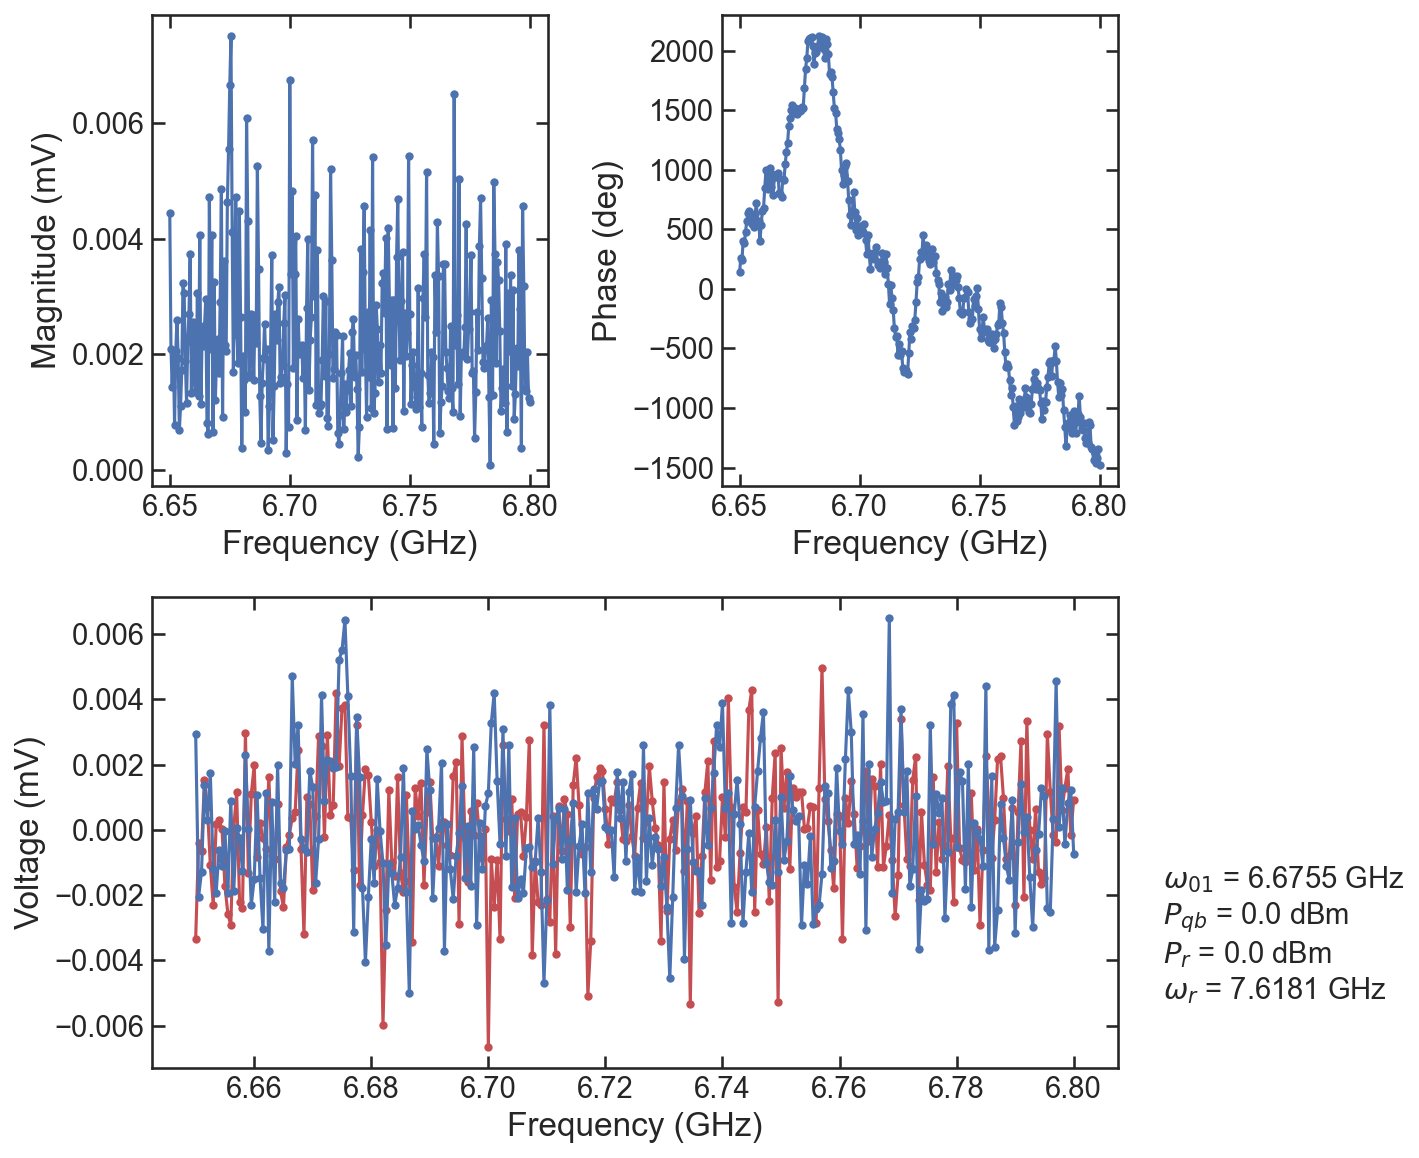

In [32]:
pf.qubit_spec_plot(data,qb_pars=qb.pars,find_peaks=True, amp_q_scaling=amp_q_scaling)

## Run broad spectroscopy scan on qubit

In [33]:
qb._instruments.set('sa','frequency',6e9)
qb.pars['resettime']['qubit'] = int(5e3)

Setting sa frequency to 6000000000.0.


In [34]:
qb.update_value('n_avg',2000)
qb.update_value('rr_freq', 7.61805e9)
qb.update_value('rr_IF', 50e6)
qb.update_value('rr_LO', qb.pars['rr_freq'] - qb.pars['rr_IF'])
qb.pars['resettime']['qubit'] = int(10e3)
qb.write_pars()
df_qubit_spec = 2e6
data, job = qb.run_scan(df = df_qubit_spec, element='qubit',
                                check_mixers=False,
                                chunksize = 200e6,
                                lo_min = 6e9,
                                lo_max = 7e9,
                                amp_q_scaling = 1,
                                on_off=True,
                                saturation_dur = 20e3,                   
                                showprogress=True,
                                savedata=False)

Updating n_avg to 2000
Updating rr_freq to 7618050000.0
Updating rr_IF to 50000000.0
Updating rr_LO to 7568050000.0
Setting readout_LO frequency to 7568050000.0.


  0%|          | 0/6 [00:00<?, ?it/s]

Updating qubit_LO to 6000000000.0
Setting qubit_LO frequency to 6000000000.0.
2024-04-25 14:06:08,769 - qm - INFO     - Performing health check
2024-04-25 14:06:08,800 - qm - INFO     - Health check passed
2024-04-25 14:06:09,588 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:06:09,882 - qm - INFO     - Executing program


 17%|█▋        | 1/6 [00:31<02:35, 31.17s/it]

Updating qubit_LO to 6200000000.0
Setting qubit_LO frequency to 6200000000.0.
2024-04-25 14:06:39,728 - qm - INFO     - Performing health check
2024-04-25 14:06:39,749 - qm - INFO     - Health check passed
2024-04-25 14:06:40,461 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:06:40,826 - qm - INFO     - Executing program


 33%|███▎      | 2/6 [01:02<02:04, 31.02s/it]

Updating qubit_LO to 6400000000.0
Setting qubit_LO frequency to 6400000000.0.
2024-04-25 14:07:10,657 - qm - INFO     - Performing health check
2024-04-25 14:07:10,685 - qm - INFO     - Health check passed
2024-04-25 14:07:11,533 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:07:11,783 - qm - INFO     - Executing program


 50%|█████     | 3/6 [01:33<01:33, 31.03s/it]

Updating qubit_LO to 6600000000.0
Setting qubit_LO frequency to 6600000000.0.
2024-04-25 14:07:41,815 - qm - INFO     - Performing health check
2024-04-25 14:07:41,847 - qm - INFO     - Health check passed
2024-04-25 14:07:42,716 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:07:43,014 - qm - INFO     - Executing program


 67%|██████▋   | 4/6 [02:04<01:02, 31.09s/it]

Updating qubit_LO to 6800000000.0
Setting qubit_LO frequency to 6800000000.0.
2024-04-25 14:08:12,897 - qm - INFO     - Performing health check
2024-04-25 14:08:12,927 - qm - INFO     - Health check passed
2024-04-25 14:08:13,915 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:08:14,224 - qm - INFO     - Executing program


 83%|████████▎ | 5/6 [02:35<00:31, 31.16s/it]

Updating qubit_LO to 7000000000.0
Setting qubit_LO frequency to 7000000000.0.
2024-04-25 14:08:44,337 - qm - INFO     - Performing health check
2024-04-25 14:08:44,361 - qm - INFO     - Health check passed
2024-04-25 14:08:45,091 - qm - INFO     - Sending program to QOP for compilation
2024-04-25 14:08:45,348 - qm - INFO     - Executing program


 83%|████████▎ | 5/6 [02:45<00:33, 33.12s/it]


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
pf.qubit_spec_plot(data,qb_pars=qb.pars,df=df_qubit_spec,rrFreq=qb.pars['rr_freq'],amp_q_scaling=1)